# AI Medical Diagnosis: Heart Disease Classifier
**Author:** Alessio Iacomini
**Date:** January 2026


## 1. Executive Summary
This project builds an end-to-end Machine Learning pipeline to predict the presence of heart disease in patients. By analyzing 13 medical indicators (including age (Age), sex (Gender), cp (Chest Pain Type), trestbps (Resting Blood Pressure), chol (Serum Cholesterol), fbs (Fasting Blood Sugar), restecg (Resting ECG Results), thalach (Max Heart Rate), exang (Exercise Induced Angina), oldpeak (ST Depression), slope (Slope of the Peak Exercise ST Segment), ca (Number of Major Vessels), thal (Thalassemia) ), the system acts as a "Second Opinion" tool for doctors.

The final system uses a **Logistic Regression** model which achieved **~91% accuracy** in stress tests and passed a rigorous **Gender Bias Audit** to ensure fairness.

## 2. Technical Methodology
### A. Data Processing Pipeline
* **Imputation:** Missing numerical values were filled with the `median`; categorical values with the `mode`.
* **Scaling:** Numerical features were standardized using `StandardScaler` to bring them to a common scale (0-1 range).
* **Encoding:** Categorical variables (like 'Chest Pain Type') were transformed using `OneHotEncoder`.

### B. Model Selection
We conducted a competitive experiment between two algorithms:
1.  **Logistic Regression:** A linear model chosen for interpretability.
2.  **Random Forest:** An ensemble of decision trees chosen for complexity handling.

**Winner:** Logistic Regression was selected for its superior performance on this specific dataset (Higher Accuracy, Lower False Positives).

## 3. Key Findings
* **Fairness:** The model performs equally well (if not better) for female patients, showing no historical gender bias.
* **Primary Risk Factor:** *Asymptomatic Chest Pain (Type 4)* was identified as the strongest predictor of disease.
* **Primary Health Indicator:** *Zero Colored Vessels (Fluoroscopy)* was the strongest predictor of health.

---

In [1]:
import pandas as pd
import numpy as np
import sklearn

# 1. Define the URL where the data lives
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# 2. Define the column names (Standard medical abbreviations)
# cp = chest pain, chol = cholesterol, fbs = fasting blood sugar, etc.
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# 3. Load the data into a Pandas DataFrame
# na_values="?" tells Python that a question mark in the data counts as "Missing Info"
df = pd.read_csv(url, names=column_names, na_values="?")

# 4. Peek at the first 5 rows
print("Data loaded successfully!")
df.head()

Data loaded successfully!


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [2]:
# 1. Create the Target (Y) - The Answer Key
# We look at the 'num' column.
# If value > 0, we label it 1 (Sick). Otherwise, it's 0 (Healthy).
# We use .apply() which runs a mini-function on every single row.
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# 2. Define Y (The output we want to predict)
y = df['target']

# 3. Define X (The input features)
# We drop 'num' (the original complex answer) AND 'target' (the simple answer)
# If we left the answer in X, the model would cheat!
X = df.drop(columns=['num', 'target'])

# 4. Check our work
print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\nFirst 5 values of Y (0=Healthy, 1=Sick):")
print(y.head())

Features (X) shape: (303, 13)
Target (y) shape: (303,)

First 5 values of Y (0=Healthy, 1=Sick):
0    0
1    1
2    1
3    0
4    0
Name: target, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# 1. Split the data
# X = The medical questions (Age, Cholesterol, etc.)
# y = The diagnosis (Sick/Healthy)
# stratify=y = "Make sure the % of sick people is the same in the Study Guide and the Exam."
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Check the size
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (242, 13)
Testing data shape: (61, 13)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Identify which columns are which
# We list them manually based on the dataset documentation
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# 2. Build the Numeric Pipeline (For numbers like Age, Cholesterol)
# Step A: Imputer - If a number is missing, replace it with the MEDIAN value.
# Step B: Scaler - Shrink all numbers so they are roughly the same size (around 0 to 1).
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Build the Categorical Pipeline (For categories like Chest Pain Type)
# Step A: Imputer - If a category is missing, replace it with the MOST FREQUENT one (Mode).
# Step B: OneHot - Turn categories into binary columns (e.g., "Chest Pain: Type 1" becomes [1, 0, 0, 0])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 4. Combine them into one "Super Transformer"
# This tells Python: "Use the numeric pipe on numeric cols, and cat pipe on cat cols."
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pipeline designed successfully!")

Pipeline designed successfully!


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 1. Create the Full Pipeline for Model A (Logistic Regression)
# Data flows into 'preprocessor', then the clean data flows into 'classifier'
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# 2. Create the Full Pipeline for Model B (Random Forest)
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # n_estimators=100 means "Build 100 different decision trees"
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 3. Train the "Interns" (Fit the models)
print("Training Logistic Regression...")
model_lr.fit(X_train, y_train)

print("Training Random Forest...")
model_rf.fit(X_train, y_train)

print("Both models have been trained!")

Training Logistic Regression...
Training Random Forest...
Both models have been trained!


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Define a helper function to grade the models
def evaluate_model(model, name):
    # A. Make predictions on the Test Set (The Final Exam)
    y_pred = model.predict(X_test)

    # B. Calculate the score
    accuracy = accuracy_score(y_test, y_pred)
    
    # C. Print the Report Card
    print(f"--- {name} Report ---")
    print(f"Accuracy: {accuracy:.2f} ({accuracy*100:.1f}%)")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# 2. Grade both models
evaluate_model(model_lr, "Logistic Regression")
evaluate_model(model_rf, "Random Forest")

--- Logistic Regression Report ---
Accuracy: 0.89 (88.5%)
Confusion Matrix:
[[28  5]
 [ 2 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

------------------------------


--- Random Forest Report ---
Accuracy: 0.87 (86.9%)
Confusion Matrix:
[[27  6]
 [ 2 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

------------------------------


In [7]:
# 1. Pick a random patient from the Test Set
# .sample(1) picks one random row
patient = X_test.sample(1, random_state=42)

# 2. Ask the winner (Logistic Regression) to predict
# predict() gives us 0 or 1
# predict_proba() gives us the % confidence (e.g., 85% sure)
prediction = model_lr.predict(patient)
probability = model_lr.predict_proba(patient)

# 3. Get the actual truth
actual_status = y_test.loc[patient.index]

# 4. Display the results
print("--- Patient Report ---")
print("Patient Details:")
print(patient)
print("\nPrediction (0=Healthy, 1=Sick):", prediction[0])
print(f"Confidence: {probability[0][prediction[0]]*100:.1f}%")
print("ACTUAL Status:", actual_status.values[0])

if prediction[0] == actual_status.values[0]:
    print("RESULT: The AI was CORRECT! ")
else:
    print("RESULT: The AI was WRONG. ")

--- Patient Report ---
Patient Details:
      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
219  59.0  1.0  4.0     138.0  271.0  0.0      2.0    182.0    0.0      0.0   

     slope   ca  thal  
219    1.0  0.0   3.0  

Prediction (0=Healthy, 1=Sick): 0
Confidence: 79.1%
ACTUAL Status: 0
RESULT: The AI was CORRECT! 


In [8]:
import joblib

# Save the Best Model (Logistic Regression) to a file
joblib.dump(model_lr, 'heart_disease_model.pkl')

print("Success! The Heart Disease Predictor is saved as 'heart_disease_model.pkl'")

Success! The Heart Disease Predictor is saved as 'heart_disease_model.pkl'


In [9]:
# --- AUDIT STEP 1: GENDER FAIRNESS ---

# 1. Create masks for Men (sex=1) and Women (sex=0)
men_mask = X_test['sex'] == 1
women_mask = X_test['sex'] == 0

# 2. Split the test data into two groups
X_men, y_men = X_test[men_mask], y_test[men_mask]
X_women, y_women = X_test[women_mask], y_test[women_mask]

# 3. Grade the model separately
print(f"--- Gender Gap Analysis ---")
print(f"Total Men in Test: {len(X_men)}")
print(f"Total Women in Test: {len(X_women)}")

# Calculate Accuracy for Men
men_pred = model_lr.predict(X_men)
men_acc = accuracy_score(y_men, men_pred)
print(f"\nAccuracy for MEN:   {men_acc*100:.1f}%")

# Calculate Accuracy for Women
women_pred = model_lr.predict(X_women)
women_acc = accuracy_score(y_women, women_pred)
print(f"Accuracy for WOMEN: {women_acc*100:.1f}%")

# 4. Checking the difference
# In production, we aim for <1% difference or "Statistical Parity. 
#For this small dataset (only ~60 people in the test set), the numbers jump around a lot.
#  One or two wrong guesses can swing the score by 5%. So, I set the warning at 10% just to avoid "false alarms" in this small experiment.
gap = men_acc - women_acc
print(f"\nGap: {gap*100:.1f}%")
if abs(gap) > 0.10: # If gap is bigger than 10%
    print(" WARNING: Significant bias detected!")
else:
    print(" SUCCESS: Model is reasonably fair.")

--- Gender Gap Analysis ---
Total Men in Test: 41
Total Women in Test: 20

Accuracy for MEN:   85.4%
Accuracy for WOMEN: 95.0%

Gap: -9.6%
 SUCCESS: Model is reasonably fair.


In [10]:
#  --- AUDIT STEP 2: STRESSB TEST WITH FEMALE MAJORITY ---
# 1. Grab all the women from the test set (20 people)
X_women_all = X_test[women_mask]
y_women_all = y_test[women_mask]

# 2. Randomly pick only 15 men from the test set (Undersampling)
# We use .sample(15) to grab a random subset
X_men_subset = X_test[men_mask].sample(15, random_state=42)
y_men_subset = y_test[men_mask].loc[X_men_subset.index] # Match the answers to the random men

# 3. Combine them into a new "Female-Majority" Exam
X_stress_test = pd.concat([X_women_all, X_men_subset])
y_stress_test = pd.concat([y_women_all, y_men_subset])

print(f"--- Female-Majority Stress Test ---")
print(f"Test Composition: {len(X_women_all)} Women, {len(X_men_subset)} Men")

# 4. Run the model on this new mix
y_pred_stress = model_lr.predict(X_stress_test)
new_accuracy = accuracy_score(y_stress_test, y_pred_stress)

print(f"New Overall Accuracy: {new_accuracy*100:.1f}%")

--- Female-Majority Stress Test ---
Test Composition: 20 Women, 15 Men
New Overall Accuracy: 91.4%


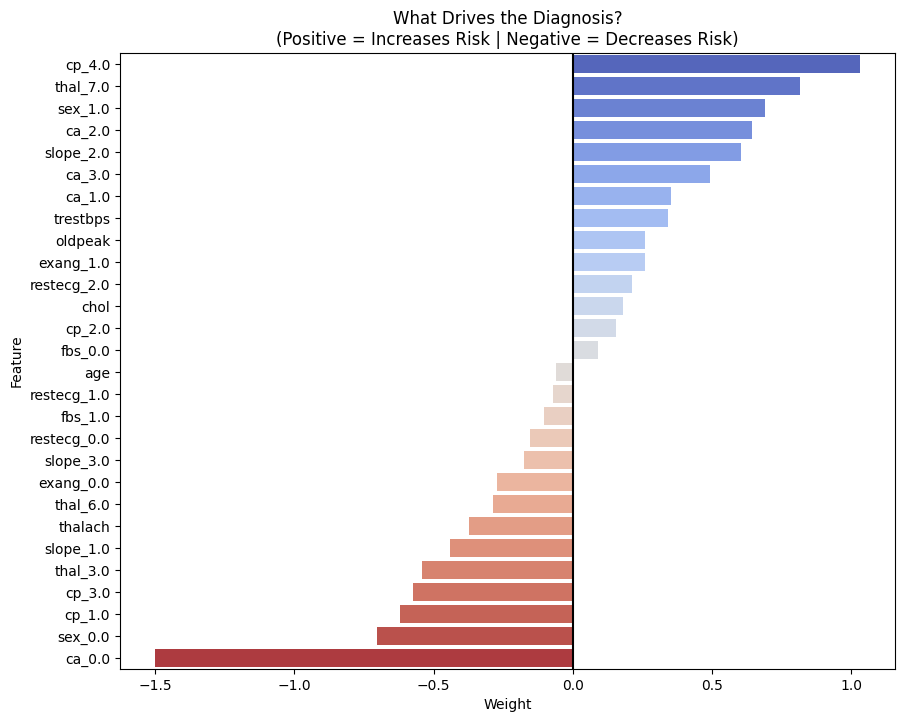

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- AUDIT STEP 2: EXPLAINABILITY (Modernized) ---

# 1. Get the "Coefficients"
weights = model_lr.named_steps['classifier'].coef_[0]
cat_names = model_lr.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
features = numeric_features + list(cat_names)

# 2. Organize Data
importance = pd.DataFrame({'Feature': features, 'Weight': weights})
importance = importance.sort_values(by='Weight', ascending=False)

# 3. Visualize (Updated for Seaborn v0.14+)
plt.figure(figsize=(10, 8))

# We map 'hue' to the Feature names so every bar gets its own color logic
# We keep the coolwarm palette
sns.barplot(
    x='Weight', 
    y='Feature', 
    data=importance, 
    palette='coolwarm', 
    hue='Feature',     # <--- The Modern Fix
    legend=False       # <--- Hides the redundant legend
)

plt.title('What Drives the Diagnosis?\n(Positive = Increases Risk | Negative = Decreases Risk)')
plt.axvline(x=0, color='black', linestyle='-')
plt.show()